In [173]:
import os
import sys
import timeit
import numpy as np
import theano
import theano.tensor as T
import lasagne
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.regularization import regularize_network_params, l2, l1
import gzip
import pickle
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Nonlinear function y = x ** 2 - 0.5 

In [164]:
def func(x):
    return x ** 2 -0.5

In [215]:
SIGMA = 0.05
data_ponits = 100

In [219]:
X = 2 * np.random.random(size=data_ponits) - 1
y = func(X) + SIGMA * np.random.randn(data_ponits)

X_test = 2 * np.random.random(size=data_ponits) - 1  
y_test = func(X_test) + SIGMA * np.random.randn(data_ponits)

y = np.asarray(y, dtype=np.float32)
X = np.asarray(X, dtype=np.float32)
X = X.reshape((X.shape[0], 1))

y_test = np.asarray(y_test, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
X_test = X_test.reshape((X_test.shape[0], 1))

# Conclusion: if we random sample x to form the train set, then the MLP doesn't overfit. (as long as your sample is reasonably large, like 100 )

## for example, if we use the trainning sample below, then model won't overfit

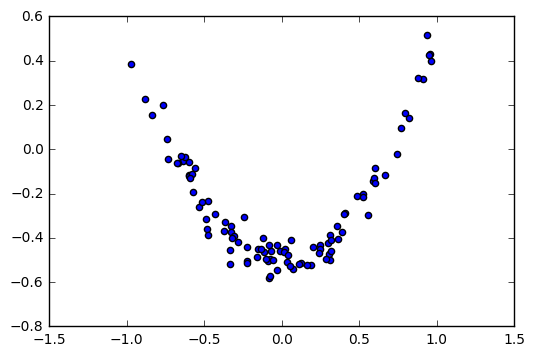

In [220]:
plt.scatter(X,y)

In [221]:
Batch_SIZE = 1

In [222]:
def build_model(input_var, hidden_neurons=1024):
    l_in = InputLayer(shape=(None, 1), input_var=input_var)
    l_hidden1 = DenseLayer(l_in, num_units=hidden_neurons)
    l_hidden2 = DenseLayer(l_hidden1, num_units=hidden_neurons)
    l_out = DenseLayer(l_hidden1, num_units=1, nonlinearity=None)
    return l_out

In [223]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [224]:
    num_epochs = 500
    learn_rate = 0.1
    hidden_neurons = 1024
    input_var = T.matrix('inputs')
    target_var = T.vector('targets')
    network = build_model(input_var, hidden_neurons)
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    #l2_penalty = regularize_network_params(network, l2)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adagrad(loss, params, learning_rate=learn_rate)
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss = test_loss.mean()
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], test_loss)
    get_output = theano.function([input_var], test_prediction)
    time_list = []
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, Batch_SIZE, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
            # Then we print the results for this epoch:
        time_delta = time.time() - start_time
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_delta))
        time_list.append(time_delta)
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, Batch_SIZE, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    final_train_err = train_err
    final_test_err = test_err 
    avg_epoch_time = np.mean(time_list)
    y_pred = get_output(X)
    y_test_pred = get_output(X_test)

Epoch 1 of 500 took 0.041s
  training loss:		0.326962
Epoch 2 of 500 took 0.041s
  training loss:		0.009309
Epoch 3 of 500 took 0.040s
  training loss:		0.007212
Epoch 4 of 500 took 0.040s
  training loss:		0.005792
Epoch 5 of 500 took 0.040s
  training loss:		0.005529
Epoch 6 of 500 took 0.041s
  training loss:		0.005283
Epoch 7 of 500 took 0.045s
  training loss:		0.004482
Epoch 8 of 500 took 0.040s
  training loss:		0.004805
Epoch 9 of 500 took 0.040s
  training loss:		0.005439
Epoch 10 of 500 took 0.040s
  training loss:		0.004535
Epoch 11 of 500 took 0.042s
  training loss:		0.004683
Epoch 12 of 500 took 0.045s
  training loss:		0.004392
Epoch 13 of 500 took 0.040s
  training loss:		0.004502
Epoch 14 of 500 took 0.040s
  training loss:		0.003908
Epoch 15 of 500 took 0.040s
  training loss:		0.004232
Epoch 16 of 500 took 0.042s
  training loss:		0.004055
Epoch 17 of 500 took 0.045s
  training loss:		0.003987
Epoch 18 of 500 took 0.041s
  training loss:		0.004116
Epoch 19 of 500 too

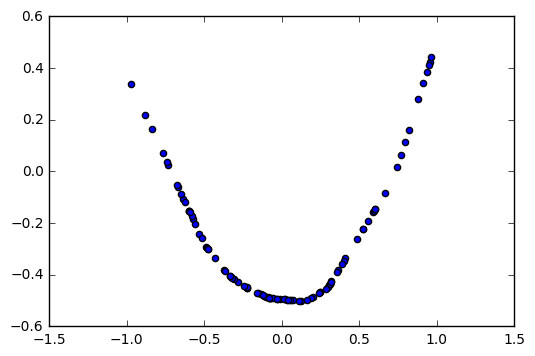

In [225]:
plt.scatter(X,y_pred)

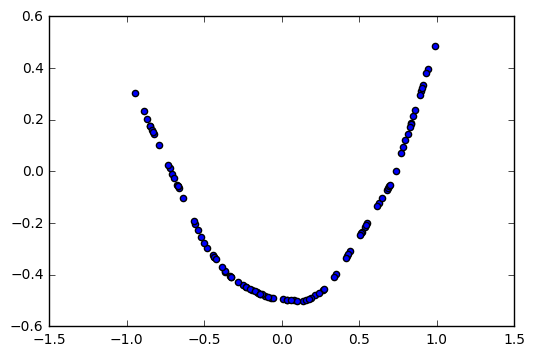

In [226]:
plt.scatter(X_test,y_test_pred)

# to make the model overfit, we have to systematically sample x:

In [244]:
data_ponits= 500
SIGMA = 0.2
X = np.linspace(-1,1,data_ponits)
y = func(X) + SIGMA * np.random.randn(data_ponits)

X_test = 2 * np.random.random(size=data_ponits) - 1  
y_test = func(X_test) + SIGMA * np.random.randn(data_ponits)
y = np.asarray(y, dtype=np.float32)
X = np.asarray(X, dtype=np.float32)
X = X.reshape((X.shape[0], 1))
y_test = np.asarray(y_test, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
X_test = X_test.reshape((X_test.shape[0], 1))

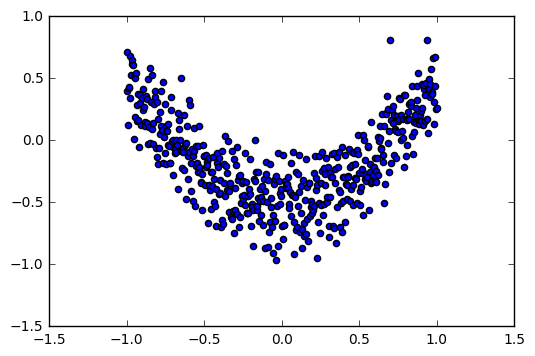

In [245]:
plt.scatter(X,y)

In [246]:
    num_epochs = 500
    learn_rate = 0.1
    hidden_neurons = 4096
    input_var = T.matrix('inputs')
    target_var = T.vector('targets')
    network = build_model(input_var, hidden_neurons)
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    #l2_penalty = regularize_network_params(network, l2)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adagrad(loss, params, learning_rate=learn_rate)
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss = test_loss.mean()
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], test_loss)
    get_output = theano.function([input_var], test_prediction)
    time_list = []
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, Batch_SIZE, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
            # Then we print the results for this epoch:
        time_delta = time.time() - start_time
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_delta))
        time_list.append(time_delta)
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, Batch_SIZE, shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    final_train_err = train_err
    final_test_err = test_err 
    avg_epoch_time = np.mean(time_list)
    y_pred = get_output(X)
    y_test_pred = get_output(X_test)

Epoch 1 of 500 took 0.203s
  training loss:		0.585861
Epoch 2 of 500 took 0.205s
  training loss:		0.047554
Epoch 3 of 500 took 0.215s
  training loss:		0.046215
Epoch 4 of 500 took 0.211s
  training loss:		0.044599
Epoch 5 of 500 took 0.214s
  training loss:		0.043254
Epoch 6 of 500 took 0.208s
  training loss:		0.043573
Epoch 7 of 500 took 0.209s
  training loss:		0.043165
Epoch 8 of 500 took 0.209s
  training loss:		0.043070
Epoch 9 of 500 took 0.215s
  training loss:		0.042924
Epoch 10 of 500 took 0.209s
  training loss:		0.043165
Epoch 11 of 500 took 0.212s
  training loss:		0.043189
Epoch 12 of 500 took 0.281s
  training loss:		0.042862
Epoch 13 of 500 took 0.221s
  training loss:		0.040750
Epoch 14 of 500 took 0.199s
  training loss:		0.042836
Epoch 15 of 500 took 0.203s
  training loss:		0.042161
Epoch 16 of 500 took 0.198s
  training loss:		0.042220
Epoch 17 of 500 took 0.204s
  training loss:		0.042424
Epoch 18 of 500 took 0.197s
  training loss:		0.042827
Epoch 19 of 500 too

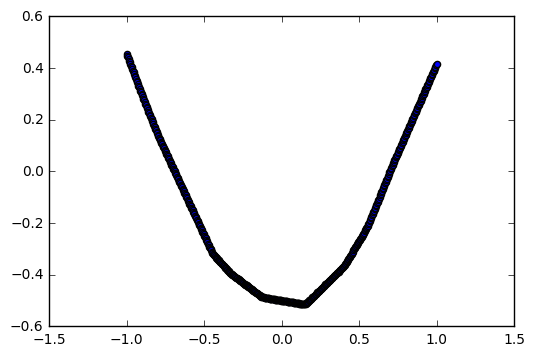

In [247]:
plt.scatter(X, y_pred)